In [ ]:
pip install -U albumentations

In [86]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from PIL import Image

class ImageDataGenerator(Sequence):
    def __init__(self, image_filenames, mask_filenames, image_size=(160, 160), batch_size=32, shuffle=True):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            zipped_lists = list(zip(self.image_filenames, self.mask_filenames))
            np.random.shuffle(zipped_lists)
            self.image_filenames, self.mask_filenames = zip(*zipped_lists)

    def __getitem__(self, idx):
        batch_x_indices = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_indices = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_x = np.array([self.transform_image(Image.open(fname).resize(self.image_size)) for fname in batch_x_indices])
        batch_y = np.array([self.transform_mask(Image.open(fname).resize(self.image_size)) for fname in batch_y_indices])
        
        return batch_x, batch_y

    def transform_image(self, img):
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = np.array(img, dtype=np.float32)
        img /= 255.0
        return img

    def transform_mask(self, img):
        if img.mode != 'L':
            img = img.convert('L')
        img = np.array(img, dtype=np.float32)
        img /= 255.0
        img = np.round(img)
        return img

import os

def load_filenames(image_dir, mask_dir):
    image_filenames = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_filenames = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
    
    # Assuming filenames without the directory and extension are the same for images and masks:
    image_filenames.sort(key=lambda x: os.path.splitext(os.path.basename(x))[0])
    mask_filenames.sort(key=lambda x: os.path.splitext(os.path.basename(x))[0])
    
    return image_filenames, mask_filenames

# Load filenames
image_dir = r'C:\Users\shaif\Downloads\Compressed\DUTS-TE\DUTS-TE\DUTS-TE-Image'
mask_dir = r'C:\Users\shaif\Downloads\Compressed\DUTS-TE\DUTS-TE\DUTS-TE-Mask'
image_filenames, mask_filenames = load_filenames(image_dir, mask_dir)

# Verify that images and masks are correctly matched
for img, mask in zip(image_filenames, mask_filenames):
    assert os.path.splitext(os.path.basename(img))[0] == os.path.splitext(os.path.basename(mask))[0], "Mismatched files"

# Shuffle and split the data
indices = list(range(len(image_filenames)))
np.random.shuffle(indices)
split_idx = int(0.8 * len(indices))  # 80% training, 20% validation

train_image_filenames = [image_filenames[i] for i in indices[:split_idx]]
train_mask_filenames = [mask_filenames[i] for i in indices[:split_idx]]
val_image_filenames = [image_filenames[i] for i in indices[split_idx:]]
val_mask_filenames = [mask_filenames[i] for i in indices[split_idx:]]

# Create data generators
train_gen = ImageDataGenerator(train_image_filenames, train_mask_filenames)
val_gen = ImageDataGenerator(val_image_filenames, val_mask_filenames)


In [107]:
import os
from PIL import Image
import numpy as np

# Directories containing the images and masks
image_dir = r'C:\Users\shaif\Downloads\Compressed\DUTS-TE\DUTS-TE\DUTS-TE-Image'
mask_dir = r'C:\Users\shaif\Downloads\Compressed\DUTS-TE\DUTS-TE\DUTS-TE-Mask'

# Function to load images from a directory into a list
def load_images(directory, is_mask=False):
    images = []
    filenames = sorted(os.listdir(directory))  # Sorting to ensure matching images and masks
    for filename in filenames:
        if filename.endswith(('.jpg', '.png')):  # Check for both jpg and png files
            file_path = os.path.join(directory, filename)
            image = Image.open(file_path)
            if is_mask:
                image = image.convert('L')  # Convert mask to grayscale
            image = image.resize((224, 224))  # Resize images if required
            images.append(np.array(image))
    return images

# Load images and masks
x_train = load_images(image_dir)
y_train = load_images(mask_dir, is_mask=True)

# Convert lists to numpy arrays if needed
x_train = np.array(x_train)
y_train = np.array(y_train)

print(f'Loaded {len(x_train)} images and {len(y_train)} masks')


Loaded 5019 images and 5019 masks


In [108]:
y_train= y_train/255
x_train= x_train/255

X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
batch_size = 128

In [109]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import pickle

import os
import tensorflow as tf
input_shape = (224,224,3)
pool_size = (2, 2)

model=tf.keras.models.Sequential([
# Normalizes incoming inputs. First layer needs the input shape to work
tf.keras.layers.BatchNormalization(input_shape=input_shape),
tf.keras.layers.Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv1'),
tf.keras.layers.Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv2'),
# Pooling 1
tf.keras.layers.MaxPooling2D(pool_size=pool_size),

tf.keras.layers.Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv3'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv4'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv5'),
tf.keras.layers.Dropout(0.2),
 # Pooling 2
tf.keras.layers.MaxPooling2D(pool_size=pool_size),

tf.keras.layers.Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv6'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv7'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv8'),
# Pooling 3
tf.keras.layers.MaxPooling2D(pool_size=pool_size),
# Upsample 1
tf.keras.layers.UpSampling2D(size=pool_size),
#Deconv
tf.keras.layers.Conv2DTranspose(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv1'),
tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv2'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv3'),
tf.keras.layers.Dropout(0.25),
# Upsample 2
tf.keras.layers.UpSampling2D(size=pool_size),

tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv4'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv5'),
# Upsample 3
tf.keras.layers.UpSampling2D(size=pool_size),

tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv6'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv7'),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv8'),
tf.keras.layers.Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv9Finalone')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_7 (Batc  (None, 224, 224, 3)      12        
 hNormalization)                                                 
                                                                 
 Conv1 (Conv2D)              (None, 222, 222, 8)       224       
                                                                 
 Conv2 (Conv2D)              (None, 220, 220, 16)      1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 110, 110, 16)     0         
 2D)                                                             
                                                                 
 Conv3 (Conv2D)              (None, 108, 108, 16)      2320      
                                                                 
 dropout_30 (Dropout)        (None, 108, 108, 16)     

In [111]:
train_datagen = ImageDataGenerator(channel_shift_range=0.2)
train_datagen.fit(X_train)

model.compile(optimizer='Adam', loss='mean_squared_error',metrics=['accuracy'])

model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size), 
                steps_per_epoch=len(X_train)/batch_size,
                epochs=20, verbose=1, validation_data=(X_val, y_val))

Epoch 1/20
31/31 [==============================] - 29s 672ms/step - loss: 0.1347 - accuracy: 0.8316 - val_loss: 0.1197 - val_accuracy: 0.8437
Epoch 2/20
31/31 [==============================] - 16s 498ms/step - loss: 0.1122 - accuracy: 0.8364 - val_loss: 0.1259 - val_accuracy: 0.8437
Epoch 3/20
31/31 [==============================] - 16s 503ms/step - loss: 0.1063 - accuracy: 0.8372 - val_loss: 0.1258 - val_accuracy: 0.8437
Epoch 4/20
31/31 [==============================] - 16s 517ms/step - loss: 0.1036 - accuracy: 0.8383 - val_loss: 0.1272 - val_accuracy: 0.8437
Epoch 5/20
31/31 [==============================] - 16s 512ms/step - loss: 0.1011 - accuracy: 0.8397 - val_loss: 0.1167 - val_accuracy: 0.8437
Epoch 6/20
31/31 [==============================] - 16s 522ms/step - loss: 0.1012 - accuracy: 0.8397 - val_loss: 0.1163 - val_accuracy: 0.8437
Epoch 7/20
31/31 [==============================] - 30s 955ms/step - loss: 0.1001 - accuracy: 0.8403 - val_loss: 0.0994 - val_accuracy: 0.8437

In [114]:
v = model.predict(X_val)

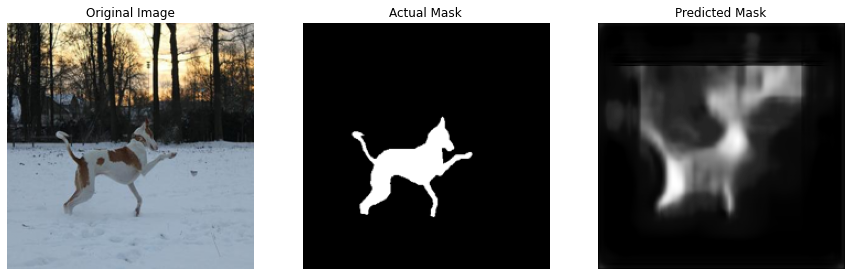

In [118]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

predicted_mask = v[2]

# Load and display the original image and mask for visual reference
original_image = X_val[2]
original_mask = y_val[2]

# Plot the original image, actual mask, and predicted mask
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(original_mask, cmap='gray')
ax[1].set_title('Actual Mask')
ax[1].axis('off')

ax[2].imshow(predicted_mask, cmap='gray')
ax[2].set_title('Predicted Mask')
ax[2].axis('off')

plt.show()
